In [1]:
# !pip install numpy==1.19.5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
import tensorflow as tf


from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

WINDOW_SIZE=16

c:\users\gamepc\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\gamepc\miniconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\gamepc\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def import_data():
    """
    Import data and split into features and labels
    """
    data = pd.read_csv('data_kia.csv').values
    x_data = data[:, :51]
    y_data = data[:, 52]
    return x_data, y_data

data, labels = import_data()
data

array([[268.8, 0.0, 5.2, ..., -8.8, 0, -3.4],
       [243.2, 0.0, 6.1, ..., -0.2, 0, -3.6],
       [217.6, 0.0, 5.2, ..., -0.2, 0, -3.6],
       ...,
       [345.6, 0.0, 6.6, ..., 0.0, 0, -13.2],
       [332.8, 0.0, 5.7, ..., 0.0, 0, -13.3],
       [281.6, 0.0, 5.2, ..., -0.1, 0, -13.3]], dtype=object)

In [3]:
scaler = preprocessing.MinMaxScaler().fit(data)

In [4]:
def normalize_data(rows, max_columns=None, min_columns=None):
    try:
        if max_columns == None:
            max_columns = rows.max(axis=0)
    except:
        pass
    
    try:
        if min_columns == None:
            min_columns = rows.min(axis=0)
    except:
        pass
    norm_rows = np.empty(rows.shape)
    for i in range(rows.shape[1]):
        for j in range(rows.shape[0]):
            if ((max_columns[i]-min_columns[i])>0):
                norm_rows[j][i] = (rows[j][i] - min_columns[i])/(max_columns[i]-min_columns[i])
            else:
                norm_rows[j][i] = 0
    return norm_rows, max_columns, min_columns

normal_data, max_columns, min_columns = normalize_data(data)
normal_data


array([[0.02459016, 0.        , 0.052     , ..., 0.07650273, 0.        ,
        0.49030656],
       [0.02224824, 0.        , 0.061     , ..., 0.54644809, 0.        ,
        0.49011556],
       [0.01990632, 0.        , 0.052     , ..., 0.54644809, 0.        ,
        0.49011556],
       ...,
       [0.03161593, 0.        , 0.066     , ..., 0.55737705, 0.        ,
        0.48094738],
       [0.03044496, 0.        , 0.057     , ..., 0.55737705, 0.        ,
        0.48085188],
       [0.02576112, 0.        , 0.052     , ..., 0.55191257, 0.        ,
        0.48085188]])

In [5]:
def onehot_labels(labels, num_labels=10, window_size=WINDOW_SIZE):
    """
    Converts label array to 1-hot encoded vectors
    """

    result = []

    for l in labels:
        label_vector = [0] * num_labels
        index = ord(l) - ord('A')
        label_vector[index] = 1

        result.append(label_vector)

    return np.array([result[i] for i in range(0, len(result) - window_size, (window_size // 2))])

# y_data = tf.convert_to_tensor(onehot_labels(labels), dtype=tf.float64)
y_data = onehot_labels(labels)
len(y_data)

11796

In [6]:
def package_data(data, window_size=WINDOW_SIZE):
    result = []
    for i in range(0, len(data) - window_size, window_size // 2):
        result.append(data[i:i + window_size])

    return (result)
# x_data = tf.convert_to_tensor(package_data(normal_data), dtype=tf.float64)
x_data = package_data(data)
len(x_data)

11796

In [7]:
def add_noise(data, noise_level, std_level):
    noise_map = np.random.rand(data.shape[0], data.shape[1])

    non_noise_indices = np.where(noise_map > noise_level)
    
    noise = np.random.normal(0, std_level, data.shape)
    noise[non_noise_indices] = 0

    return data + noise
   


In [8]:
# create train and test batches
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data[:], test_size=0.10
)

x_train = normalize_data(np.array(x_train), max_columns, min_columns)[0]
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape), print(x_test.shape)
print(y_train.shape, y_test.shape)

(10616, 16, 51)
(1180, 16, 51)
(10616, 10) (1180, 10)


In [9]:
def create_model(learning_rate=1e-4, window_size=WINDOW_SIZE, num_features=51):
    model = Sequential()
    model.add(LSTM(160, input_shape=(window_size, num_features), return_sequences=True ))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(200, ))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['categorical_crossentropy', 'accuracy'])

    return model

In [16]:
model = create_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.fit(x_train, y_train, epochs=500, batch_size=128, validation_split=(0.05/0.9), callbacks=[callback])

Epoch 1/500
79/79 [==============================] - 1s 18ms/step - loss: 2.3568 - categorical_crossentropy: 2.3568 - accuracy: 0.1252 - val_loss: 2.2751 - val_categorical_crossentropy: 2.2751 - val_accuracy: 0.1424
Epoch 2/500
79/79 [==============================] - 1s 9ms/step - loss: 2.2647 - categorical_crossentropy: 2.2647 - accuracy: 0.1565 - val_loss: 2.2337 - val_categorical_crossentropy: 2.2337 - val_accuracy: 0.1695
Epoch 3/500
79/79 [==============================] - 1s 8ms/step - loss: 2.2105 - categorical_crossentropy: 2.2105 - accuracy: 0.1721 - val_loss: 2.1712 - val_categorical_crossentropy: 2.1712 - val_accuracy: 0.1814
Epoch 4/500
79/79 [==============================] - 1s 8ms/step - loss: 2.1624 - categorical_crossentropy: 2.1624 - accuracy: 0.1886 - val_loss: 2.1286 - val_categorical_crossentropy: 2.1286 - val_accuracy: 0.1797
Epoch 5/500
79/79 [==============================] - 1s 9ms/step - loss: 2.1295 - categorical_crossentropy: 2.1295 - accuracy: 0.1990 - val

Epoch 39/500
79/79 [==============================] - 1s 9ms/step - loss: 1.4705 - categorical_crossentropy: 1.4705 - accuracy: 0.4021 - val_loss: 1.5558 - val_categorical_crossentropy: 1.5558 - val_accuracy: 0.3695
Epoch 40/500
79/79 [==============================] - 1s 8ms/step - loss: 1.4547 - categorical_crossentropy: 1.4547 - accuracy: 0.4053 - val_loss: 1.4803 - val_categorical_crossentropy: 1.4803 - val_accuracy: 0.3915
Epoch 41/500
79/79 [==============================] - 1s 8ms/step - loss: 1.4438 - categorical_crossentropy: 1.4438 - accuracy: 0.4136 - val_loss: 1.5324 - val_categorical_crossentropy: 1.5324 - val_accuracy: 0.3898
Epoch 42/500
79/79 [==============================] - 1s 8ms/step - loss: 1.4187 - categorical_crossentropy: 1.4187 - accuracy: 0.4194 - val_loss: 1.4069 - val_categorical_crossentropy: 1.4069 - val_accuracy: 0.4356
Epoch 43/500
79/79 [==============================] - 1s 8ms/step - loss: 1.3928 - categorical_crossentropy: 1.3928 - accuracy: 0.4276 -

79/79 [==============================] - 1s 9ms/step - loss: 0.8918 - categorical_crossentropy: 0.8918 - accuracy: 0.6059 - val_loss: 1.0205 - val_categorical_crossentropy: 1.0205 - val_accuracy: 0.5559
Epoch 77/500
79/79 [==============================] - 1s 8ms/step - loss: 0.8918 - categorical_crossentropy: 0.8918 - accuracy: 0.5988 - val_loss: 1.1162 - val_categorical_crossentropy: 1.1162 - val_accuracy: 0.5322
Epoch 78/500
79/79 [==============================] - 1s 7ms/step - loss: 0.8707 - categorical_crossentropy: 0.8707 - accuracy: 0.6079 - val_loss: 0.9679 - val_categorical_crossentropy: 0.9679 - val_accuracy: 0.5559
Epoch 79/500
79/79 [==============================] - 1s 10ms/step - loss: 0.8534 - categorical_crossentropy: 0.8534 - accuracy: 0.6242 - val_loss: 1.2467 - val_categorical_crossentropy: 1.2467 - val_accuracy: 0.5288
Epoch 80/500
79/79 [==============================] - 1s 10ms/step - loss: 0.8410 - categorical_crossentropy: 0.8410 - accuracy: 0.6262 - val_loss: 

Epoch 114/500
79/79 [==============================] - 1s 7ms/step - loss: 0.5753 - categorical_crossentropy: 0.5753 - accuracy: 0.7730 - val_loss: 1.1830 - val_categorical_crossentropy: 1.1830 - val_accuracy: 0.5712
Epoch 115/500
79/79 [==============================] - 1s 7ms/step - loss: 0.5467 - categorical_crossentropy: 0.5467 - accuracy: 0.7836 - val_loss: 0.7985 - val_categorical_crossentropy: 0.7985 - val_accuracy: 0.6797
Epoch 116/500
79/79 [==============================] - 1s 7ms/step - loss: 0.5632 - categorical_crossentropy: 0.5632 - accuracy: 0.7737 - val_loss: 1.3053 - val_categorical_crossentropy: 1.3053 - val_accuracy: 0.5593
Epoch 117/500
79/79 [==============================] - 1s 7ms/step - loss: 0.5473 - categorical_crossentropy: 0.5473 - accuracy: 0.7813 - val_loss: 0.7573 - val_categorical_crossentropy: 0.7573 - val_accuracy: 0.6797
Epoch 118/500
79/79 [==============================] - 1s 7ms/step - loss: 0.5356 - categorical_crossentropy: 0.5356 - accuracy: 0.7

Epoch 152/500
79/79 [==============================] - 1s 10ms/step - loss: 0.3975 - categorical_crossentropy: 0.3975 - accuracy: 0.8474 - val_loss: 0.8399 - val_categorical_crossentropy: 0.8399 - val_accuracy: 0.7085
Epoch 153/500
79/79 [==============================] - 1s 9ms/step - loss: 0.3858 - categorical_crossentropy: 0.3858 - accuracy: 0.8488 - val_loss: 0.6382 - val_categorical_crossentropy: 0.6382 - val_accuracy: 0.7542
Epoch 154/500
79/79 [==============================] - 1s 9ms/step - loss: 0.3724 - categorical_crossentropy: 0.3724 - accuracy: 0.8576 - val_loss: 1.3838 - val_categorical_crossentropy: 1.3838 - val_accuracy: 0.6000
Epoch 155/500
79/79 [==============================] - 1s 9ms/step - loss: 0.3881 - categorical_crossentropy: 0.3881 - accuracy: 0.8494 - val_loss: 1.1305 - val_categorical_crossentropy: 1.1305 - val_accuracy: 0.6254
Epoch 156/500
79/79 [==============================] - 1s 9ms/step - loss: 0.3787 - categorical_crossentropy: 0.3787 - accuracy: 0.

Epoch 190/500
79/79 [==============================] - 1s 11ms/step - loss: 0.2650 - categorical_crossentropy: 0.2650 - accuracy: 0.9016 - val_loss: 0.7057 - val_categorical_crossentropy: 0.7057 - val_accuracy: 0.7678
Epoch 191/500
79/79 [==============================] - 1s 10ms/step - loss: 0.2497 - categorical_crossentropy: 0.2497 - accuracy: 0.9063 - val_loss: 0.8101 - val_categorical_crossentropy: 0.8101 - val_accuracy: 0.7322
Epoch 192/500
79/79 [==============================] - 1s 9ms/step - loss: 0.2834 - categorical_crossentropy: 0.2834 - accuracy: 0.8921 - val_loss: 1.0198 - val_categorical_crossentropy: 1.0198 - val_accuracy: 0.6881
Epoch 193/500
79/79 [==============================] - 1s 10ms/step - loss: 0.2523 - categorical_crossentropy: 0.2523 - accuracy: 0.9060 - val_loss: 0.5928 - val_categorical_crossentropy: 0.5928 - val_accuracy: 0.8085
Epoch 194/500
79/79 [==============================] - 1s 10ms/step - loss: 0.2327 - categorical_crossentropy: 0.2327 - accuracy:

Epoch 228/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1667 - categorical_crossentropy: 0.1667 - accuracy: 0.9394 - val_loss: 0.5199 - val_categorical_crossentropy: 0.5199 - val_accuracy: 0.8237
Epoch 229/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1868 - categorical_crossentropy: 0.1868 - accuracy: 0.9299 - val_loss: 0.8288 - val_categorical_crossentropy: 0.8288 - val_accuracy: 0.7559
Epoch 230/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1791 - categorical_crossentropy: 0.1791 - accuracy: 0.9352 - val_loss: 1.0720 - val_categorical_crossentropy: 1.0720 - val_accuracy: 0.6966
Epoch 231/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1694 - categorical_crossentropy: 0.1694 - accuracy: 0.9409 - val_loss: 0.7560 - val_categorical_crossentropy: 0.7560 - val_accuracy: 0.7712
Epoch 232/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1805 - categorical_crossentropy: 0.1805 - accuracy: 0.9

Epoch 266/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1356 - categorical_crossentropy: 0.1356 - accuracy: 0.9519 - val_loss: 0.5969 - val_categorical_crossentropy: 0.5969 - val_accuracy: 0.8102
Epoch 267/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1322 - categorical_crossentropy: 0.1322 - accuracy: 0.9540 - val_loss: 0.9213 - val_categorical_crossentropy: 0.9213 - val_accuracy: 0.7508
Epoch 268/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1313 - categorical_crossentropy: 0.1313 - accuracy: 0.9550 - val_loss: 0.6055 - val_categorical_crossentropy: 0.6055 - val_accuracy: 0.8068
Epoch 269/500
79/79 [==============================] - 1s 10ms/step - loss: 0.1177 - categorical_crossentropy: 0.1177 - accuracy: 0.9593 - val_loss: 0.6631 - val_categorical_crossentropy: 0.6631 - val_accuracy: 0.8000
Epoch 270/500
79/79 [==============================] - 1s 13ms/step - loss: 0.1188 - categorical_crossentropy: 0.1188 - accuracy: 0

Epoch 304/500
79/79 [==============================] - 1s 9ms/step - loss: 0.0957 - categorical_crossentropy: 0.0957 - accuracy: 0.9660 - val_loss: 0.4938 - val_categorical_crossentropy: 0.4938 - val_accuracy: 0.8525
Epoch 305/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1025 - categorical_crossentropy: 0.1025 - accuracy: 0.9654 - val_loss: 0.6625 - val_categorical_crossentropy: 0.6625 - val_accuracy: 0.8119
Epoch 306/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1004 - categorical_crossentropy: 0.1004 - accuracy: 0.9650 - val_loss: 0.6492 - val_categorical_crossentropy: 0.6492 - val_accuracy: 0.8119
Epoch 307/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1076 - categorical_crossentropy: 0.1076 - accuracy: 0.9636 - val_loss: 0.6735 - val_categorical_crossentropy: 0.6735 - val_accuracy: 0.8017
Epoch 308/500
79/79 [==============================] - 1s 9ms/step - loss: 0.1001 - categorical_crossentropy: 0.1001 - accuracy: 0.9

In [17]:
data_sets = []
std_levels = [0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]
for i in std_levels:
    data_sets.append(normalize_data(add_noise(x_test, 1, i), max_columns=max_columns, min_columns=min_columns)[0])
    
packaged_data = []
for data_set in data_sets:
    packaged_data.append(np.array(data_set))

In [18]:
predictions = []
for i, p in enumerate(packaged_data):
    predictions.append(model.predict(p[:]))

In [19]:
percentages = []

for j, prediction in enumerate(predictions):
    correct_count = 0

    for i, p in enumerate(prediction):
        # check if predicted labels is the same as test label
        if np.argmax(p) == np.argmax(y_test[i]):
            correct_count += 1
    
    percentages.append(correct_count/len(prediction))
# print(f"Accuracy: {correct_count} / {len(prediction)} = {correct_count / len(prediction) * 100:.2f}%")

percentages

[0.8322033898305085,
 0.8322033898305085,
 0.8313559322033899,
 0.8364406779661017,
 0.811864406779661,
 0.8033898305084746,
 0.8008474576271186,
 0.7796610169491526,
 0.7805084745762711,
 0.6661016949152543]

[0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]


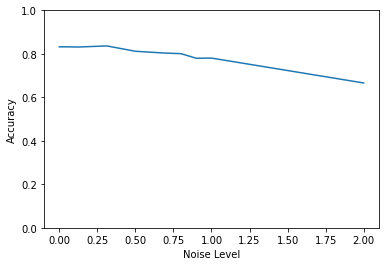

In [20]:
print(std_levels)
plt.plot(std_levels, percentages)
plt.ylim((0.0, 1.0))
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.show()

[0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]


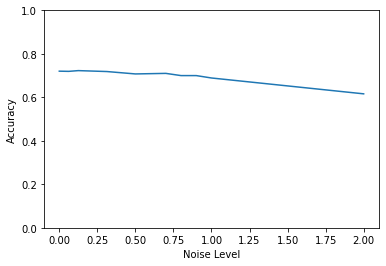

In [28]:
print(std_levels)
plt.plot(std_levels, percentages)
plt.ylim((0.0, 1.0))
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.show()

In [39]:
model.save("99accuracy.h5")